In [1]:
import glob
import pandas as pd
import time
import random
import matplotlib.pyplot as plt
%matplotlib inline

from biom import Table, load_table
from skbio import DistanceMatrix, OrdinationResults
from skbio.stats.composition import closure
from gemelli.rpca import joint_rpca, rpca_table_processing
from sklearn.model_selection import train_test_split

#turn off warnings
import warnings
warnings.filterwarnings("ignore")

## Data pre-processing

Only need to run these blocks once

In [2]:
data_path = '/Users/bec5786/Desktop/Shenhav Lab/Joint-RPCA/Case studies/iHMP/Data/'
data_path_ihmp = '{}ihmp_data/'.format(data_path)

In [3]:
# import and match the data the same as in ../../simulations-benchmarking/3.0-ihmp-benchmarks.ipynb
# we will also save each table with all the data for that table
# for exploration non-jointly based on the joint samples
tables = {omics_.split('/')[-1].split('.')[0]:rpca_table_processing(load_table(omics_),
                                                                    min_sample_count=0,
                                                                    min_feature_count=0,
                                                                    min_feature_frequency=0)
          for omics_ in glob.glob('{}*.biom'.format(data_path_ihmp))
          if not any ('_' + str(d_) in omics_ for d_ in [10, 8, 6, 4, 2, 1])}
metadata = pd.read_csv('{}sample-metadata.txt'.format(data_path_ihmp), sep='\t', index_col=0)

# add pathways instead of ECs (easier to interpret)
tbl_ = pd.read_csv('{}additional-data/pathabundances_3.tsv'.format(data_path_ihmp), sep='\t', index_col=0)
tbl_ = tbl_[[('UNINTEGRATED' not in x) and ('UNMAPPED' not in x) for x in tbl_.index]]
tbl_.columns = [c.replace('_pathabundance_cpm','') for c in tbl_.columns]
tbl_ = tbl_.loc[tbl_.sum(1) > 0, tbl_.sum(0) > 0]
tbl_ = Table(tbl_.values, tbl_.index, tbl_.columns)
tables['meta_t_ecs'] = tbl_.copy()

In [4]:
tables

{'virome_virmap_analysis': 260 x 645 <class 'biom.table.Table'> with 2490 nonzero entries (1% dense),
 'meta_t_ecs': 8291 x 805 <class 'biom.table.Table'> with 368525 nonzero entries (5% dense),
 'shared_meta_g_taxonomic_profiles': 181 x 1630 <class 'biom.table.Table'> with 51942 nonzero entries (17% dense),
 'HMP2_proteomics_ecs': 830 x 450 <class 'biom.table.Table'> with 56580 nonzero entries (15% dense),
 'HMP2_metabolomics': 81867 x 546 <class 'biom.table.Table'> with 27348904 nonzero entries (61% dense)}

In [5]:
# make table/metadata pair for each dataset of all samples in the data
tables_metdata_unshared = {}
for omics_, table_ in tables.items():
    print(omics_)
    metadata_omic = metadata.copy()
    table_omic = table_.copy()
    shared_samps = set(table_omic.ids()) & set(metadata.index)
    table_omic = table_omic.filter(shared_samps)
    table_omic = rpca_table_processing(table_omic, min_sample_count=0,
                                       min_feature_count=0,
                                       min_feature_frequency=0)
    metadata_omic = metadata_omic.reindex(shared_samps)
    table_omic_df = pd.DataFrame(table_omic.matrix_data.toarray(),
                                 table_omic.ids('observation'),
                                 table_omic.ids())
    # these omics output in % abundance so have to use relative counts.
    # possibly try to re-scale back to counts?
    if omics_ in ['shared_meta_g_taxonomic_profiles','meta_t_ecs','HMP2_metabolomics']:
        table_omic_df = table_omic_df.apply(closure)
    tables_metdata_unshared[omics_] = [table_omic, table_omic_df, metadata_omic]
tables_metdata_unshared.keys()

virome_virmap_analysis
meta_t_ecs
shared_meta_g_taxonomic_profiles
HMP2_proteomics_ecs
HMP2_metabolomics


dict_keys(['virome_virmap_analysis', 'meta_t_ecs', 'shared_meta_g_taxonomic_profiles', 'HMP2_proteomics_ecs', 'HMP2_metabolomics'])

In [6]:
shared_samps = set.intersection(*[set(t_.ids()) for t_ in tables.values()]) & set(metadata.index)
metadata_shared = metadata.reindex(shared_samps)
metadata_shared['diagnosis_binned'] = [x.replace('UC','IBD').replace('CD','IBD')
                                       for x in metadata_shared.diagnosis]
# re-close metaG/T data
metadata_shared = metadata_shared.reindex(shared_samps)
tables_shared = {t_k:t_.copy().filter(shared_samps) for t_k, t_ in tables.items()}
for t_ in ['shared_meta_g_taxonomic_profiles','meta_t_ecs','HMP2_metabolomics']:
    tbl_tmp = tables_shared[t_].to_dataframe().copy()
    tbl_tmp = tbl_tmp.apply(closure)
    tables_shared[t_] = Table(tbl_tmp.values, tbl_tmp.index, tbl_tmp.columns)

train_, test_ = train_test_split(metadata_shared, shuffle=True,
                                 stratify=metadata_shared['diagnosis'],
                                 test_size=0.25)
metadata_shared['train_test'] = 'train'
metadata_shared.loc[test_.index, 'train_test'] = 'test'
#metadata_shared.to_csv('../data/sample-metadata-plus-train-tests-case-study.csv')
metadata_shared.diagnosis.value_counts()

CD        61
nonIBD    44
UC        30
Name: diagnosis, dtype: int64

In [7]:
#save all tables in biom format
for k_, t_ in tables_shared.items():
   with open('../data/{}.biom'.format(k_), 'w') as f:
       f.write(t_.to_json(generated_by='BIOM-Format'))

## Load pre-processed data

In [8]:
omic_keys = [omics_.split('/')[-1].split('.')[0] for omics_ in glob.glob('../data/*.biom')]

In [9]:
#load the data
tables_shared = {k_: load_table('../data/{}.biom'.format(k_)) for k_ in omic_keys}
metadata_shared = pd.read_csv('../data/sample-metadata-plus-train-tests-case-study.csv', index_col=0)
tables_shared

{'virome_virmap_analysis': 260 x 135 <class 'biom.table.Table'> with 505 nonzero entries (1% dense),
 'meta_t_ecs': 8291 x 135 <class 'biom.table.Table'> with 59744 nonzero entries (5% dense),
 'shared_meta_g_taxonomic_profiles': 181 x 135 <class 'biom.table.Table'> with 4465 nonzero entries (18% dense),
 'HMP2_proteomics_ecs': 830 x 135 <class 'biom.table.Table'> with 15760 nonzero entries (14% dense),
 'HMP2_metabolomics': 81867 x 135 <class 'biom.table.Table'> with 6886507 nonzero entries (62% dense)}

In [10]:
for omic in tables_shared.keys():
    print(omic)
    tbl_test = tables_shared[omic].to_dataframe().copy()
    print(tbl_test.sum(0)[0:5])
    print()

virome_virmap_analysis
MSM5LLDS       363.0
MSM6J2IQ         6.0
HSM5MD62      3857.0
HSM5MD5D    267904.0
ESM5MEDN      1903.0
dtype: float64

meta_t_ecs
CSM5MCVN    1.0
CSM5MCXL    1.0
CSM5MCY8    1.0
CSM5MCZ3    1.0
CSM5MCZF    1.0
dtype: float64

shared_meta_g_taxonomic_profiles
CSM5MCVN    1.0
CSM5MCXL    1.0
CSM5MCY8    1.0
CSM5MCZ3    1.0
CSM5MCZF    1.0
dtype: float64

HMP2_proteomics_ecs
CSM5MCVN    3473.0
CSM5MCXL    1210.0
CSM5MCY8    1388.0
CSM5MCZ3    1965.0
CSM5MCZF     291.0
dtype: float64

HMP2_metabolomics
MSM5LLDS    1.0
MSM6J2IQ    1.0
HSM5MD62    1.0
HSM5MD5D    1.0
ESM5MEDN    1.0
dtype: float64



## Joint-RPCA

In [16]:
#generate subsets of metabolomics data
metab_all = tables_shared['HMP2_metabolomics'].copy()
metabolites_sub = {}
for factor in [0.01, 0.02]: 
    #get metabolomics table
    metab = tables_shared['HMP2_metabolomics'].copy()
    #number of features to keep
    n_features = int(metab.shape[0]*factor)
    #randomly select n_features
    feature_ids = random.sample(list(metab.ids(axis='observation')), n_features)
    #filter table
    metabolites_sub[factor] = metab.filter(feature_ids, axis='observation')
    #sanity check
    print('Metabolomics: {}% of features: {}'.format(factor*100, metabolites_sub[factor].shape[0]))

Metabolomics: 1.0% of features: 818
Metabolomics: 2.0% of features: 1637


In [18]:
#create dictionary to store run time by Joint-RPCA
runtime = {}

#run Joint-RPCA on all data and subsets of metabolomics data
tables_no_metab = {k_: v_ for k_, v_ in tables_shared.items() if k_ != 'HMP2_metabolomics'}
tables_no_metab

{'virome_virmap_analysis': 260 x 135 <class 'biom.table.Table'> with 505 nonzero entries (1% dense),
 'meta_t_ecs': 8291 x 135 <class 'biom.table.Table'> with 59744 nonzero entries (5% dense),
 'shared_meta_g_taxonomic_profiles': 181 x 135 <class 'biom.table.Table'> with 4465 nonzero entries (18% dense),
 'HMP2_proteomics_ecs': 830 x 135 <class 'biom.table.Table'> with 15760 nonzero entries (14% dense)}

In [19]:
for factor in [0, 0.01, 0.02, 1]:

    if factor == 0:
        tables_use = tables_no_metab.copy()
    elif factor==1:
        tables_use = tables_shared.copy()
    else:
        tables_use = tables_shared.copy()
        tables_use['HMP2_metabolomics'] = metabolites_sub[factor].copy()

    time_start = time.perf_counter()
    ord_, dist_, cv_plt = joint_rpca([t.copy() for t in tables_shared.values()],
                                    sample_metadata=metadata_shared,
                                    train_test_column='train_test',
                                    min_feature_frequency=0,
                                    min_sample_count=0,
                                    min_feature_count=0,
                                    n_test_samples=0,
                                    max_iterations=5)
    time_elapsed = (time.perf_counter() - time_start)
    runtime['Joint-RPCA-{}'.format(factor)] = time_elapsed
    # ord_.write('../results/joint-rpca-ord.txt')
    # dist_.write('../results/joint-rpca-dist.txt')
    # cv_plt.to_csv('../results/joint-rpca-cv.txt')

In [21]:
#create df to store the run time
runtime_df = pd.DataFrame.from_dict(runtime, orient='index', columns=['time (s)'])
runtime_df.to_csv('../results/joint-rpca-runtime.csv')
#runtime_df

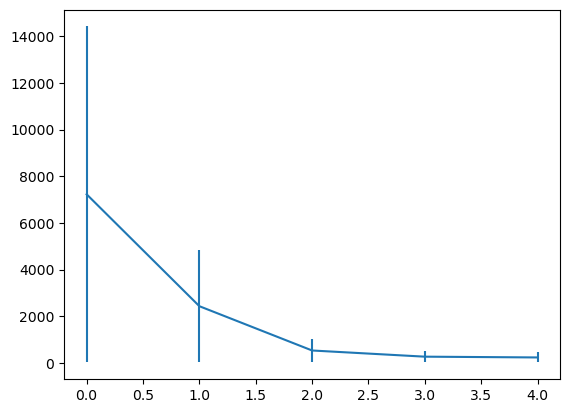

In [12]:
# ord_ = OrdinationResults.read('../results/joint-rpca-ord.txt')
# dist_ = DistanceMatrix.read('../results/joint-rpca-dist.txt')

#plot the CV results
cv_plt = pd.read_csv('../results/joint-rpca-cv.txt', index_col=0)
ordination_samples = pd.concat([ord_.samples, metadata_shared], axis=1, sort=False)
plt.errorbar(cv_plt.index, cv_plt.mean_CV, yerr=cv_plt.std_CV/2)
plt.show()